In [16]:
# General fanfare to download
import yt
import pyxsim
import matplotlib.pyplot as plt
import soxs
import numpy as np
import re
import struct
import sys
import warnings
from io import open
import h5py
import astropy
from matplotlib.colors import LogNorm
from astropy.wcs import WCS
from astropy.io import fits
import numpy as np


In [2]:
#make sure to have and check these versions are up to date
print("Numpy:      {}".format(np.__version__))
print("SOXS:     {}".format(soxs.__version__))
print("YT:     {}".format(yt.__version__))
print("Pyxsim:     {}".format(pyxsim.__version__))

Numpy:      1.25.1
SOXS:     4.8.2
YT:     4.3.0
Pyxsim:     4.4.1.dev10+g6f05a2d


# Loading in Data

## Loading in Athena ++

In [19]:
import yt
from yt.units import Msun, pc, kyr

units_override = {
    "length_unit": (1.0, "pc"),
    "time_unit": (1.0, "kyr"),
    "mass_unit": (1.0, "Msun"),
}

ds = yt.load("/Volumes/Extern/torus_rst.out2.00350.athdf",units_override=units_override, unit_system="cgs",
             magnetic_normalization="lorentz_heaviside",default_species_fields='ionized')


yt : [WARNING  ] 2024-05-11 17:24:25,970 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2024-05-11 17:24:25,971 Overriding length_unit: 1.0 pc.
yt : [INFO     ] 2024-05-11 17:24:25,972 Overriding time_unit: 1.0 kyr.
yt : [INFO     ] 2024-05-11 17:24:25,973 Overriding mass_unit: 1.0 Msun.
yt : [WARNING  ] 2024-05-11 17:24:25,974 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-05-11 17:24:26,083 Parameters: current_time              = 350.00012
yt : [INFO     ] 2024-05-11 17:24:26,084 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-05-11 17:24:26,086 Parameters: domain_left_edge          = [-5. -5. -5.]
yt : [INFO     ] 2024-05-11 17:24:26,086 Parameters: domain_right_edge         = [5. 5. 5.]
yt : [INFO     ] 2024-05-11 17:24:26,087 Parameters: cosmological_simulation   = 0


## Loading in RAMSES

In [46]:
import yt

units_override = {
    "length_unit": (1.0, "pc"),
    "time_unit": (1.0, "kyr"),
    "mass_unit": (1.0,"msun")
}

dsRAM = yt.load("/Volumes/Extern/output_00056/info_00056.txt",units_override=units_override, unit_system="cgs", default_species_fields="ionized") 
#loading in data default_species_fields="ionized" is necessary for later portions


yt : [WARNING  ] 2024-04-29 09:03:54,738 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2024-04-29 09:03:54,739 Overriding length_unit: 1.0 pc.
yt : [INFO     ] 2024-04-29 09:03:54,739 Overriding time_unit: 1.0 kyr.
yt : [INFO     ] 2024-04-29 09:03:54,740 Overriding mass_unit: 1.0 Msun.
yt : [INFO     ] 2024-04-29 09:03:54,818 Parameters: current_time              = 1100.04999633396
yt : [INFO     ] 2024-04-29 09:03:54,819 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-29 09:03:54,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-29 09:03:54,821 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-04-29 09:03:54,821 Parameters: cosmological_simulation   = 0


In [20]:
#Making the H_p0_number_density field that is required by default for the pyxsim.make_column_density_map
#only for the Athena simulation
 
T_neut = 10**4 # define some temperature below which the gas is neutral

def _neutral_h_density(field, data):

    nH = data['gas', 'H_nuclei_density']

    fac = np.zeros_like(nH.d)

    fac[data["gas", "temperature"] < T_neut] = 1.0

    return fac*nH

In [21]:
ds.add_field(("gas","H_p0_number_density"), _neutral_h_density, sampling_type="local", units="cm**-3")

In [22]:
dd = ds.all_data()

In [47]:
ddRAM = dsRAM.all_data()

# Creating the Synthetic Xray data 

#### follows similar format as https://hea-www.cfa.harvard.edu/~jzuhone/pyxsim/cookbook/Thermal_Emission.html

In [9]:
source_model = pyxsim.CIESourceModel("apec", 0.05, 11.0, 6000, Zmet=1.0, kT_min=0.025,kT_max=20, max_density = 1.0e-18)
#Zmet= metallicity, kT_min= Minimum temperature = 0.025,
#pyxsim.ThermalSourceModel("apec", 0.05, 11.0, 6000, Zmet=1.0, kT_min=0.025,kT_max=20, max_density = 1.0e-20) # attempt max_density = 1.0e-18
# max density found based on yt.PhasePlot
#spectral model, eV min, eV max, number of channels


pyxsim : [INFO     ] 2024-04-28 16:56:32,738 kT_min = 0.025 keV
pyxsim : [INFO     ] 2024-04-28 16:56:32,739 kT_max = 20 keV


In [48]:
source_modelRAM = pyxsim.CIESourceModel("apec", 0.05, 11.0, 6000, Zmet=1.0, kT_min=0.025,kT_max=20, max_density = 1.0e-18)
#Zmet= metallicity, kT_min= Minimum temperature = 0.025,
# max density found based on yt.PhasePlot 
#spectral model, eV min, eV max, number of channels


pyxsim : [INFO     ] 2024-04-29 09:06:11,113 kT_min = 0.025 keV
pyxsim : [INFO     ] 2024-04-29 09:06:11,114 kT_max = 20 keV


In [49]:
# Pick big numbers! (for exptime and area)
#The point of this first step is to create a Monte-Carlo sample 
#from which to draw smaller sub-samples for mock observations

exp_time = (2000.0, "ks") # Exposure time 1Ms = 1000 ks
area = (1500.0, "cm**2") # Collecting area 10m^2 = 1000 cm**2 we've been using 1500
redshift = 0.0 # because the source is local
dist = (8.18, "kpc") # distance to the galactic center 

# Calculate necessary rotation for Athena model 

In [15]:
# since the model is made on the Galactic plane we need to rotate it to an inclination of 66 deg and a position angle of 22 deg
from scipy.ndimage import rotate

inclination_angle = np.deg2rad(66)
position_angle = np.deg2rad(22)

#yflip2 = np.deg2rad(90)



# Define rotation matrix around z-axis (position angle)
Rtot = np.array([[np.cos(inclination_angle), np.sin(inclination_angle)*np.sin(position_angle), -np.sin(inclination_angle)*np.cos(position_angle)],
               [0, np.cos(position_angle), np.sin(position_angle)],
               [np.sin(inclination_angle), -np.cos(inclination_angle)*np.sin(position_angle), np.cos(inclination_angle)*np.cos(position_angle)]])




Rfin = np.linalg.inv(Rtot)



Thenormal_vector = Rfin[:,2]  #column
Thenorth_vector = Rfin[:,1]  #column
Theother_vector = Rfin[:,0]  
Thenormal_vector1 = Rtest[:,2]  # Testing for other rotations
Thenorth_vector1 = Rtest[:,1]  # Testing for other rotations



print("Rotation Matrix:")
print(Rfin)
#print(Rtest)
#print(Thenormal_vector1*-1)
#print(Thenorth_vector1*-1)
print("normal:")
print(Thenormal_vector)
print("North:")
print(Thenorth_vector)
print("---")
print ("Don't forget to mirror these values (change + and negative signs) because RA is increasing to the left and how the model is set up")
print("---")
print("Mirror Normal:")
print(Thenormal_vector*(-1))
print("Mirror North:")
print(Thenorth_vector*(-1))

print("The rotation above is not 100% accurate and we are currently still working on it so for now we are using the following vectors as our Normal and North")
print("The following vectors are from a very rough 90 degree rotation about the y-axis from the originals above")
print ("---")
L = [ 0.91354546, 0.15236623,  -0.37711965] # vector normal to cutting plane
north_vector = [ 3.74606593e-01,  -9.27183855e-01, 3.74606593e-01]
print("USE THIS NORMAL: <--")
print(L)
print("USE THIS NORTH: <--")
print(north_vector)



Rotation Matrix:
[[ 4.06736643e-01 -3.03822600e-17  9.13545458e-01]
 [ 3.42220152e-01  9.27183855e-01 -1.52366228e-01]
 [-8.47024599e-01  3.74606593e-01  3.77119649e-01]]
normal:
[ 0.91354546 -0.15236623  0.37711965]
North:
[-3.03822600e-17  9.27183855e-01  3.74606593e-01]
---
Don't forget to mirror these values (change + and negative signs) because RA is increasing to the left and how the model is set up
---
Mirror Normal:
[-0.91354546  0.15236623 -0.37711965]
Mirror North:
[ 3.03822600e-17 -9.27183855e-01 -3.74606593e-01]
The rotation above is not 100% accurate and we are currently still working on it so for now we are using the following vectors as our Normal and North
The following vectors are from a very rough 90 degree rotation about the y-axis from the originals above
---
USE THIS NORMAL: <--
[0.91354546, 0.15236623, -0.37711965]
USE THIS NORTH: <--
[0.374606593, -0.927183855, 0.374606593]


In [13]:
# This is a new routine to compute the column density map
nwidth = 128  # number of pixels in the width of the Athena map
ndepth = 128  # number of pixels in the depth of the Athena map
width=(10, "pc") #width of simulation cube

c = ds.arr([0.0, 0.0, 0.0], "code_length") #setting the center


L = [ 0.91354546, 0.15236623,  -0.37711965] # vector normal to cutting plane
north_vector = [ 3.74606593e-01,  -9.27183855e-01, 3.74606593e-01] #the North (upward facing) vector


pyxsim.make_column_density_map(
    ds,
    L,
    c,
    width,
    width,
    nwidth,
    ndepth,
    "internal_abs_REV.h5",
    north_vector=N,
)

#Takes a bit of time ~10min

Determining a cube of neutral hydrogen column density :   0%|          | 0/128 [00:00<?, ?it/s]

# Making and projecting photons

In [14]:
n_photons, n_cells = pyxsim.make_photons("my_photonstestMHD15m2Ms", dd, redshift, area, exp_time, source_model,dist = dist)
#making the photons
#careful this takes up a LOT of space 
# and takes a LOT of time (hours) especially at ~24%, 39/40%, 48% (the real test), 67%, 95%

pyxsim : [INFO     ] 2024-04-28 17:04:12,753 Observing local source at distance 8.18.
pyxsim : [INFO     ] 2024-04-28 17:04:12,756 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2024-04-28 17:04:12,758 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/118 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/17235968 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-04-28 18:04:57,313 Finished generating photons.
pyxsim : [INFO     ] 2024-04-28 18:04:57,347 Number of photons generated: 5606497937
pyxsim : [INFO     ] 2024-04-28 18:04:57,402 Number of cells with photons: 8875245


In [50]:
n_photonsRAM, n_cellsRAM = pyxsim.make_photons("my_photonstest15m2MsRAM", ddRAM, redshift, area, exp_time, source_modelRAM,dist = dist)
#making the photons
#careful this takes up a LOT of space 
# and takes a LOT of time (hours) especially at ~24%, 39/40%, 48% (the real test), 67%, 95%

pyxsim : [INFO     ] 2024-04-29 09:06:11,190 Observing local source at distance 8.18.
pyxsim : [INFO     ] 2024-04-29 09:06:11,193 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2024-04-29 09:06:11,194 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/118 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/135590365 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-04-29 12:33:35,646 Finished generating photons.
pyxsim : [INFO     ] 2024-04-29 12:33:35,647 Number of photons generated: 127550709
pyxsim : [INFO     ] 2024-04-29 12:33:35,648 Number of cells with photons: 13123634


In [17]:
# L and north are for rotation only for ATHENA
L = [ 0.91354546, 0.15236623,  -0.37711965] # vector normal to cutting plane
north_vector = [ 3.74606593e-01,  -9.27183855e-01, 3.74606593e-01]

n_events = pyxsim.project_photons("my_photonstestMHD15m2Ms", "my_photonstestMHD_REVabs_dp15m2Ms",L ,(266.42, -29),nH = 11,
                                  absorb_model="tbabs", no_shifting= False, north_vector = north_vector, column_file="internal_abs_REV.h5")

# with no_shifting = False then there will be doppler shift so you need to make one of each version
#nH = 11,
#projecting photons towards the center of the sky at Sgr A* coordinates 232.64° RA, -29° DEC 
# nH = foreground column density in units of 10^22 cm^{-2} paper (Russell et al, 2018) found it to be 11 for this
# no_shifting (optional): If set to True, the photon energies will NOT be velocity Doppler shifted. Default False.

#takes a LONG time with column files (about ~1hr but gets SCARY around 36%)

pyxsim : [INFO     ] 2024-04-29 01:10:41,564 Foreground galactic absorption: using the tbabs model and nH = 11.
pyxsim : [INFO     ] 2024-04-29 01:10:41,564 Internal absorption: using the tbabs model and column density map internal_abs.h5.


Projecting photons from cells/particles :   0%|          | 0/8875245 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-04-29 02:01:17,147 Detected 118524 events.


In [ ]:
# L and north are for rotation only for ATHENA
L = [ 0.91354546, 0.15236623,  -0.37711965] # vector normal to cutting plane
north_vector = [ 3.74606593e-01,  -9.27183855e-01, 3.74606593e-01]

n_events = pyxsim.project_photons("my_photonstestMHD15m2Ms", "my_photonstestMHD_REVabs_nodp15m2Ms",L ,(266.42, -29),nH = 11,
                                  absorb_model="tbabs", no_shifting= True, north_vector = north_vector, column_file="internal_abs_REV.h5")

# with no_shifting = False then there will be doppler shift so you need to make one of each version
#nH = 11,
#projecting photons towards the center of the sky at Sgr A* coordinates 232.64° RA, -29° DEC 
# nH = foreground column density in units of 10^22 cm^{-2} paper (Russell et al, 2018) found it to be 11 for this
# no_shifting (optional): If set to True, the photon energies will NOT be velocity Doppler shifted. Default False.

#takes a LONG time with column files (about ~1hr but gets SCARY around 36%)

In [52]:


n_eventsram = pyxsim.project_photons("my_photonstest15m2MsRAM", "my_photonstest_15m2MsRAM_dp","z",(266.42, -29),nH = 11,
                                  absorb_model="tbabs", no_shifting= False)

# with no_shifting = False then there will be doppler shift so you need to make one of each version
#nH = 11,
#projecting photons towards the center of the sky at Sgr A* coordinates 232.64° RA, -29° DEC 
# nH = foreground column density in units of 10^22 cm^{-2} paper (Russell et al, 2018) found it to be 11 for this
# no_shifting (optional): If set to True, the photon energies will NOT be velocity Doppler shifted. Default False.

#takes a LONG time with column files (about ~1hr but gets SCARY around 36%)

pyxsim : [INFO     ] 2024-04-29 12:47:48,696 Foreground galactic absorption: using the tbabs model and nH = 11.


Projecting photons from cells/particles :   0%|          | 0/13123634 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-04-29 12:49:49,031 Detected 149432 events.


In [ ]:


n_eventsram = pyxsim.project_photons("my_photonstest15m2MsRAM", "my_photonstest_15m2MsRAM_dp","z",(266.42, -29),nH = 11,
                                  absorb_model="tbabs", no_shifting= False)

# with no_shifting = False then there will be doppler shift so you need to make one of each version
#nH = 11,
#projecting photons towards the center of the sky at Sgr A* coordinates 232.64° RA, -29° DEC 
# nH = foreground column density in units of 10^22 cm^{-2} paper (Russell et al, 2018) found it to be 11 for this
# no_shifting (optional): If set to True, the photon energies will NOT be velocity Doppler shifted. Default False.

#takes a LONG time with column files (about ~1hr but gets SCARY around 36%)

In [19]:
events = pyxsim.EventList("my_photonstestMHD_REVabs_dp15m2Ms.h5")
events.write_to_simput("REVabsorption_MHD_dp15m2Ms", overwrite=True)

soxs : [INFO     ] 2024-04-29 02:44:13,909 Writing source 'abs_MHD_dp15m2Ms' to abs_MHD_dp15m2Ms_phlist.fits.


In [53]:

eventsram = pyxsim.EventList("my_photonstest_15m2MsRAM_dp.h5")
eventsram.write_to_simput("noabs_RAM_dp15m2Ms", overwrite=True)

soxs : [WARNING  ] 2024-04-29 12:49:49,543 Overwriting noabs_RAM_dp15m2Ms_phlist.fits.
soxs : [INFO     ] 2024-04-29 12:49:49,644 Writing source 'noabs_RAM_dp15m2Ms' to noabs_RAM_dp15m2Ms_phlist.fits.


### SIMULATE 

In [31]:
# make new instrument based on Chandra cycle 13
from soxs import get_instrument_from_registry, add_instrument_to_registry
new_chandra = get_instrument_from_registry("chandra_aciss_cy22")
new_chandra["name"] = "chandra_aciss_sgra_cy13" # Must change the name, otherwise an error will be thrown
new_chandra["arf"] = "asgras_src.arf" # arf of cycle 13
new_chandra["rmf"] = "asgras_src.rmf" # rmf of cycle 13


name = add_instrument_to_registry(new_chandra)

# Lynx mock observations

In [17]:
#Simulate observing with lynx
soxs.instrument_simulator("REVabsorption_MHD_dp15m2Ms_simput.fits", "REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits", (230.0,"ks"),"lynx_lxm", 
                          [266.42, -29], overwrite=True, ptsrc_bkgnd=False,foreground=False,instr_bkgnd=True)
#all of these are the potential instruments I have used 
#and lynx_lxm is overall the best but may need smaller observation times
#"xrism_resolve"
#"lynx_lxm"
#"chandra_acisi_cy22"

soxs : [INFO     ] 2024-05-13 19:19:23,526 Making observation of source in REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits.
soxs : [WARNING  ] 2024-05-13 19:19:23,950 Using local file xrs_mucal_3x10_3.0eV.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:19:23,951 Using local file xrs_mucal_3.0eV.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:19:23,952 Using local file xrs_mucal_3x10_3.0eV.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:19:24,004 Using local file xrs_mucal_3.0eV.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:19:24,261 Using local file chandra_psf.fits instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:19:24,261 Using local file chandra_psf.fits instead of the one from the database.
soxs : [INFO     ] 2024-05-13 19:19:24,429 Detecting events from source REVabsorption_MHD_dp15m2Ms.
soxs : [INFO     ] 2024-05-13 19:19:24,431 Applying energy-dependent effe

Scattering energies :   0%|          | 0/18030 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-05-13 19:19:28,567 Adding background events.
soxs : [WARNING  ] 2024-05-13 19:19:28,570 Using local file xrs_mucal_3x10_3.0eV.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:19:28,571 Using local file xrs_mucal_3x10_3.0eV.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:19:28,583 Using local file xrs_mucal_3.0eV.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:19:28,584 Using local file xrs_mucal_3.0eV.rmf instead of the one from the database.
soxs : [INFO     ] 2024-05-13 19:19:28,745 Adding in instrumental background.
soxs : [WARNING  ] 2024-05-13 19:19:28,746 Using local file lynx_lxm_particle_bkgnd.pha instead of the one from the database.
soxs : [INFO     ] 2024-05-13 19:19:28,843 Making 17156 events from the instrumental background.
soxs : [INFO     ] 2024-05-13 19:19:28,848 Writing events to file REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits.
soxs : [INFO     ] 2024-05-13 19:19:29,027

In [18]:
#Simulate observing with lynx
soxs.instrument_simulator("noabs_RAM_dp15m2Ms_simput.fits", "noabs_RAM_dp15m2Ms_lynx230ks_evt.fits", (230.0,"ks"),"lynx_lxm", 
                          [266.42, -29], overwrite=True, ptsrc_bkgnd=False,foreground=False,instr_bkgnd=True)
#all of these are the potential instruments I have used 
#and lynx_lxm is overall the best but can do a max of around 230ks observation time
#"xrism_resolve"
#"lynx_lxm"
#"chandra_acisi_cy22"

soxs : [INFO     ] 2024-05-13 19:20:03,117 Making observation of source in noabs_RAM_dp15m2Ms_lynx230ks_evt.fits.
soxs : [WARNING  ] 2024-05-13 19:20:03,213 Using local file xrs_mucal_3x10_3.0eV.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:20:03,214 Using local file xrs_mucal_3.0eV.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:20:03,215 Using local file xrs_mucal_3x10_3.0eV.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:20:03,221 Using local file xrs_mucal_3.0eV.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:20:03,429 Using local file chandra_psf.fits instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:20:03,430 Using local file chandra_psf.fits instead of the one from the database.
soxs : [INFO     ] 2024-05-13 19:20:03,614 Detecting events from source noabs_RAM_dp15m2Ms.
soxs : [INFO     ] 2024-05-13 19:20:03,615 Applying energy-dependent effective are

Scattering energies :   0%|          | 0/20072 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-05-13 19:20:07,989 Adding background events.
soxs : [WARNING  ] 2024-05-13 19:20:07,990 Using local file xrs_mucal_3x10_3.0eV.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:20:07,991 Using local file xrs_mucal_3x10_3.0eV.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:20:07,999 Using local file xrs_mucal_3.0eV.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:20:08,000 Using local file xrs_mucal_3.0eV.rmf instead of the one from the database.
soxs : [INFO     ] 2024-05-13 19:20:08,211 Adding in instrumental background.
soxs : [WARNING  ] 2024-05-13 19:20:08,212 Using local file lynx_lxm_particle_bkgnd.pha instead of the one from the database.
soxs : [INFO     ] 2024-05-13 19:20:08,501 Making 17018 events from the instrumental background.
soxs : [INFO     ] 2024-05-13 19:20:08,506 Writing events to file noabs_RAM_dp15m2Ms_lynx230ks_evt.fits.
soxs : [INFO     ] 2024-05-13 19:20:08,859 

In [19]:
#make into an image to view it
soxs.write_image("REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits", "REVabs_MHD_dp15m2Ms_lynx230ks_img.fits", overwrite=True)

In [20]:
#make into an image to view it
soxs.write_image("noabs_RAM_dp15m2Ms_lynx230ks_evt.fits", "noabs_RAM_dp15m2Ms_lynx230ks_img.fits", overwrite=True)

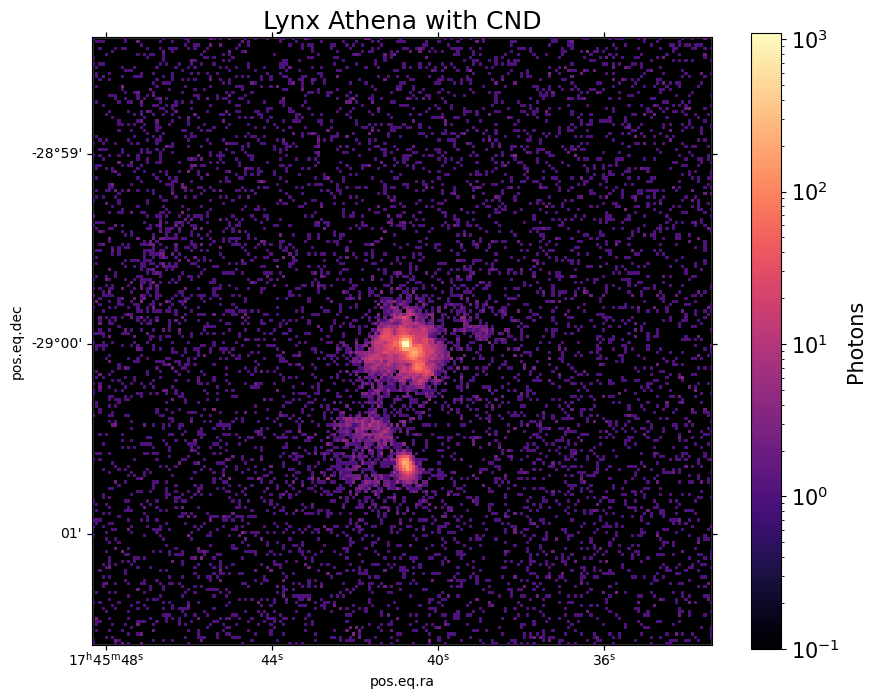

In [21]:
# print image

from astropy.io import fits
width = 400
with fits.open("REVabs_MHD_dp15m2Ms_lynx230ks_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("Lynx Athena with CND")

 

    
    fig.colorbar(p,label = 'Photons',shrink=0.80)


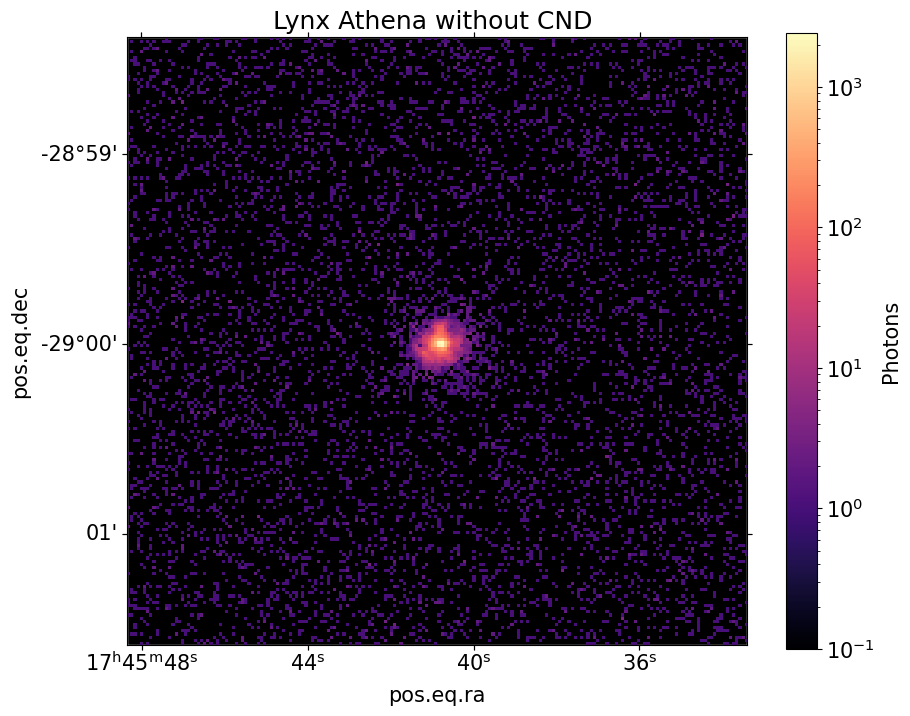

In [23]:
# print image

from astropy.io import fits
width = 400
with fits.open("noabs_RAM_dp15m2Ms_lynx230ks_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("Lynx Athena without CND ")

 

    
    fig.colorbar(p,label = 'Photons',shrink=0.80)

# XRISM mock observations

In [24]:
#Simulate observing with lynx
soxs.instrument_simulator("REVabsorption_MHD_dp15m2Ms_simput.fits", "REVabs_MHD_dp15m2Ms_xrism230ks_evt.fits", (230.0,"ks"),"xrism_resolve", 
                          [266.42, -29], overwrite=True, ptsrc_bkgnd=False,foreground=False,instr_bkgnd=True)
#all of these are the potential instruments I have used 
#and lynx_lxm is overall the best but may need smaller observation times
#"xrism_resolve"
#"lynx_lxm"
#"chandra_acisi_cy22"

soxs : [INFO     ] 2024-05-13 19:21:10,137 Making observation of source in REVabs_MHD_dp15m2Ms_xrism230ks_evt.fits.
soxs : [WARNING  ] 2024-05-13 19:21:16,136 Using local file sxs_psfimage_20140618.fits instead of the one from the database.
soxs : [INFO     ] 2024-05-13 19:21:16,652 Detecting events from source REVabsorption_MHD_dp15m2Ms.
soxs : [INFO     ] 2024-05-13 19:21:16,654 Applying energy-dependent effective area from rsl_pointsource_GVclosed.arf.
soxs : [INFO     ] 2024-05-13 19:21:16,683 Pixeling events.
soxs : [INFO     ] 2024-05-13 19:21:16,685 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-05-13 19:21:17,636 817 events were detected from the source.
soxs : [INFO     ] 2024-05-13 19:21:17,637 Scattering energies with RMF rsl_Hp_5eV.rmf.


Scattering energies :   0%|          | 0/817 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-05-13 19:21:21,167 Adding background events.
soxs : [INFO     ] 2024-05-13 19:21:26,217 Writing events to file REVabs_MHD_dp15m2Ms_xrism230ks_evt.fits.
soxs : [INFO     ] 2024-05-13 19:21:26,895 Observation complete.


In [25]:
#Simulate observing with lynx
soxs.instrument_simulator("noabs_RAM_dp15m2Ms_simput.fits", "noabs_RAM_dp15m2Ms_xrism230ks_evt.fits", (230.0,"ks"),"xrism_resolve", 
                          [266.42, -29], overwrite=True, ptsrc_bkgnd=False,foreground=False,instr_bkgnd=True)
#all of these are the potential instruments I have used 
#and lynx_lxm is overall the best but may need smaller observation times
#"xrism_resolve"
#"lynx_lxm"
#"chandra_acisi_cy22"

soxs : [INFO     ] 2024-05-13 19:21:26,901 Making observation of source in noabs_RAM_dp15m2Ms_xrism230ks_evt.fits.
soxs : [WARNING  ] 2024-05-13 19:21:30,145 Using local file sxs_psfimage_20140618.fits instead of the one from the database.
soxs : [INFO     ] 2024-05-13 19:21:30,352 Detecting events from source noabs_RAM_dp15m2Ms.
soxs : [INFO     ] 2024-05-13 19:21:30,353 Applying energy-dependent effective area from rsl_pointsource_GVclosed.arf.
soxs : [INFO     ] 2024-05-13 19:21:30,381 Pixeling events.
soxs : [INFO     ] 2024-05-13 19:21:30,383 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-05-13 19:21:30,571 1153 events were detected from the source.
soxs : [INFO     ] 2024-05-13 19:21:30,572 Scattering energies with RMF rsl_Hp_5eV.rmf.


Scattering energies :   0%|          | 0/1153 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-05-13 19:21:36,651 Adding background events.
soxs : [INFO     ] 2024-05-13 19:21:40,663 Writing events to file noabs_RAM_dp15m2Ms_xrism230ks_evt.fits.
soxs : [INFO     ] 2024-05-13 19:21:41,068 Observation complete.


In [26]:
#make into an image to view it
soxs.write_image("REVabs_MHD_dp15m2Ms_xrism230ks_evt.fits", "REVabs_MHD_dp15m2Ms_xrism230ks_img.fits", overwrite=True)

In [27]:
#make into an image to view it
soxs.write_image("noabs_RAM_dp15m2Ms_xrism230ks_evt.fits", "noabs_RAM_dp15m2Ms_xrism230ks_img.fits", overwrite=True)

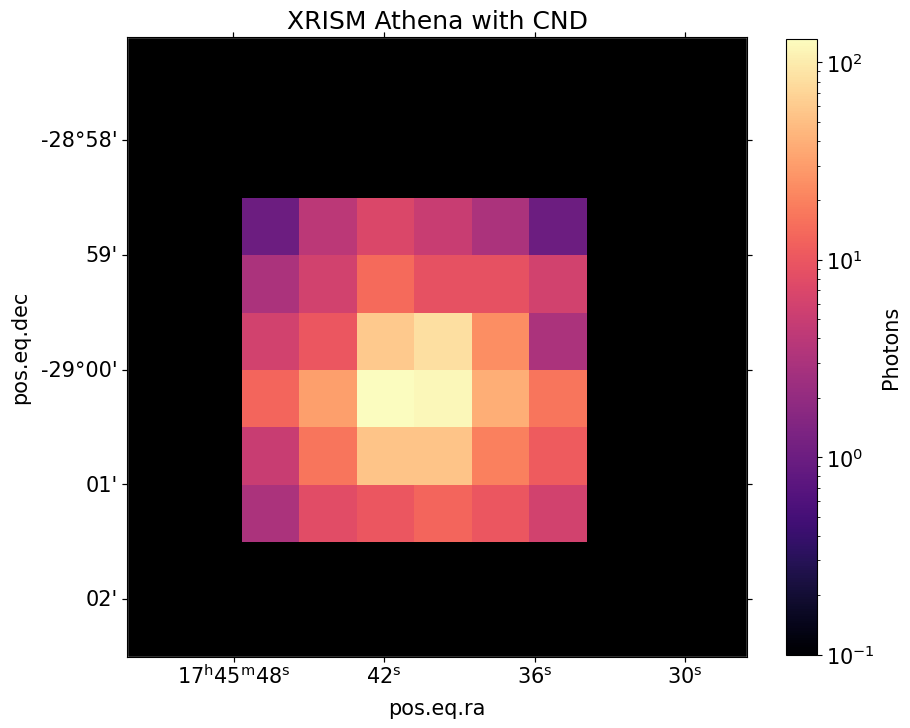

In [28]:
# print image

from astropy.io import fits
width = 20
with fits.open("REVabs_MHD_dp15m2Ms_xrism230ks_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.30*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.30*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("XRISM Athena with CND")

 

    
    fig.colorbar(p,label = 'Photons',shrink=0.80)

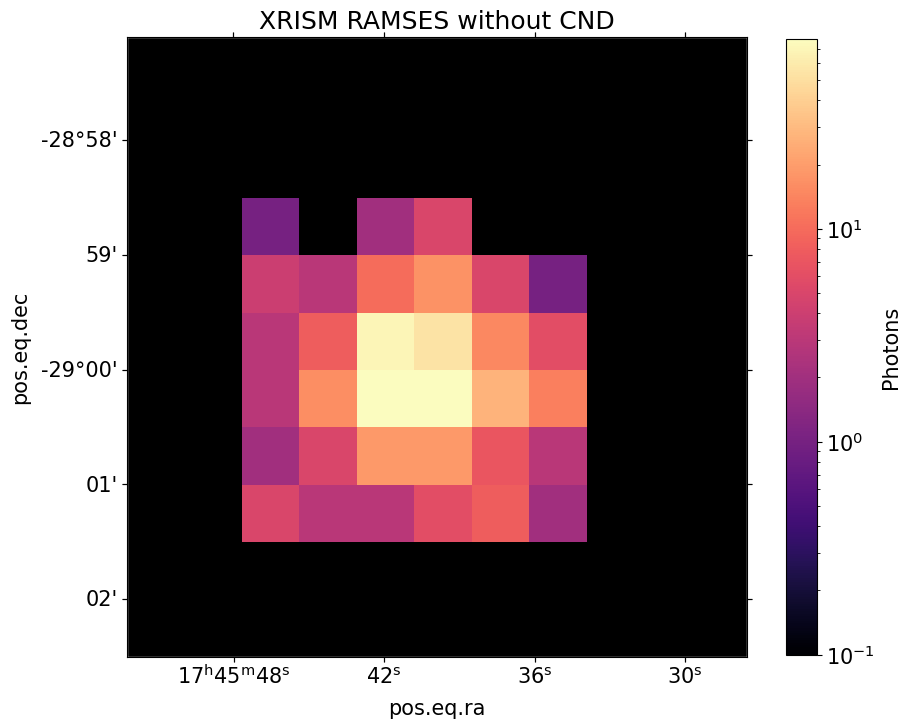

In [29]:
# print image

from astropy.io import fits
width = 20
with fits.open("noabs_RAM_dp15m2Ms_xrism100ks_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.30*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.30*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("XRISM RAMSES without CND")

 

    
    fig.colorbar(p,label = 'Photons',shrink=0.80)

# Chandra mock observations

In [32]:
soxs.instrument_simulator("REVabsorption_MHD_dp15m2Ms_simput.fits", "REVabs_MHD_dp15m2Ms_chandra230ks_evt.fits", (230.0,"ks"),"chandra_aciss_sgra_cy13", 
                          [266.42, -29], overwrite=True, ptsrc_bkgnd=False,foreground=False,instr_bkgnd=True)
#all of these are the potential instruments I have used 
#and lynx_lxm is overall the best but can do a max of around 230ks observation time
#"xrism_resolve"
#"lynx_lxm"
#"chandra_acisi_cy22"

soxs : [INFO     ] 2024-05-13 19:22:27,626 Making observation of source in REVabs_MHD_dp15m2Ms_chandra230ks_evt.fits.
soxs : [WARNING  ] 2024-05-13 19:22:27,638 Using local file asgras_src.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:27,639 Using local file asgras_src.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:27,640 Using local file asgras_src.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:27,754 Using local file asgras_src.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:27,964 Using local file chandra_psf.fits instead of the one from the database.
soxs : [INFO     ] 2024-05-13 19:22:28,332 Detecting events from source REVabsorption_MHD_dp15m2Ms.
soxs : [INFO     ] 2024-05-13 19:22:28,332 Applying energy-dependent effective area from asgras_src.arf.
soxs : [INFO     ] 2024-05-13 19:22:28,345 Pixeling events.
soxs : [INFO     ] 2024-05-13 19:22:28,347 Scatter

Scattering energies :   0%|          | 0/897 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-05-13 19:22:29,250 Adding background events.
soxs : [WARNING  ] 2024-05-13 19:22:29,252 Using local file asgras_src.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:29,253 Using local file asgras_src.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:29,259 Using local file asgras_src.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:29,260 Using local file asgras_src.rmf instead of the one from the database.
soxs : [INFO     ] 2024-05-13 19:22:29,310 Adding in instrumental background.
soxs : [INFO     ] 2024-05-13 19:22:29,643 Making 1548450 events from the instrumental background.
soxs : [INFO     ] 2024-05-13 19:22:30,022 Writing events to file REVabs_MHD_dp15m2Ms_chandra230ks_evt.fits.
soxs : [INFO     ] 2024-05-13 19:22:33,718 Observation complete.


In [33]:
soxs.instrument_simulator("noabs_RAM_dp15m2Ms_simput.fits", "noabs_RAM_dp15m2Ms_chandra230ks_evt.fits", (230.0,"ks"),"chandra_aciss_sgra_cy13", 
                          [266.42, -29], overwrite=True, ptsrc_bkgnd=False,foreground=False,instr_bkgnd=True)
#all of these are the potential instruments I have used 
#and lynx_lxm is overall the best but can do a max of around 230ks observation time
#"xrism_resolve"
#"lynx_lxm"
#"chandra_acisi_cy22"

soxs : [INFO     ] 2024-05-13 19:22:33,774 Making observation of source in noabs_RAM_dp15m2Ms_chandra230ks_evt.fits.
soxs : [WARNING  ] 2024-05-13 19:22:33,827 Using local file asgras_src.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:33,828 Using local file asgras_src.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:33,829 Using local file asgras_src.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:33,845 Using local file asgras_src.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:33,926 Using local file chandra_psf.fits instead of the one from the database.
soxs : [INFO     ] 2024-05-13 19:22:34,100 Detecting events from source noabs_RAM_dp15m2Ms.
soxs : [INFO     ] 2024-05-13 19:22:34,101 Applying energy-dependent effective area from asgras_src.arf.
soxs : [INFO     ] 2024-05-13 19:22:34,227 Pixeling events.
soxs : [INFO     ] 2024-05-13 19:22:34,230 Scattering event

Scattering energies :   0%|          | 0/1137 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-05-13 19:22:34,954 Adding background events.
soxs : [WARNING  ] 2024-05-13 19:22:34,956 Using local file asgras_src.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:34,957 Using local file asgras_src.arf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:34,968 Using local file asgras_src.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-05-13 19:22:34,969 Using local file asgras_src.rmf instead of the one from the database.
soxs : [INFO     ] 2024-05-13 19:22:35,074 Adding in instrumental background.
soxs : [INFO     ] 2024-05-13 19:22:35,463 Making 1549025 events from the instrumental background.
soxs : [INFO     ] 2024-05-13 19:22:35,893 Writing events to file noabs_RAM_dp15m2Ms_chandra230ks_evt.fits.
soxs : [INFO     ] 2024-05-13 19:22:39,302 Observation complete.


In [34]:
#make into an image to view it
soxs.write_image("REVabs_MHD_dp15m2Ms_chandra230ks_evt.fits", "REVabs_MHD_dp15m2Ms_chandra230ks_img.fits", overwrite=True)

In [35]:
#make into an image to view it
soxs.write_image("noabs_RAM_dp15m2Ms_chandra230ks_evt.fits", "noabs_RAM_dp15m2Ms_chandra230ks_img.fits", overwrite=True)

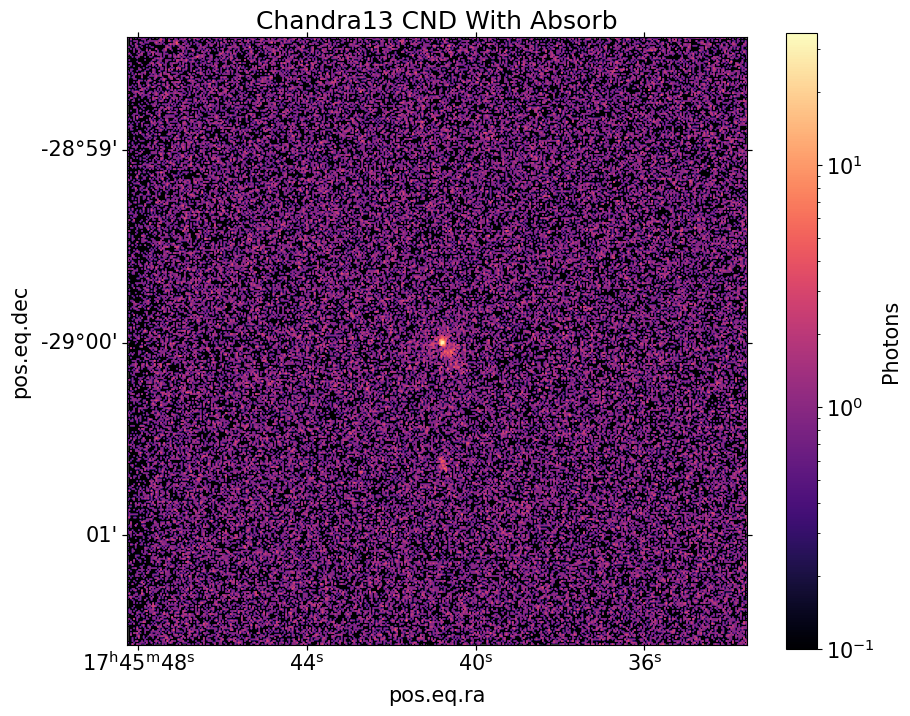

In [36]:
from astropy.io import fits
width = 800
with fits.open("REVabs_MHD_dp15m2Ms_chandra230ks_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("Chandra13 CND With Absorb")

 

    
    fig.colorbar(p,label = 'Photons',shrink=0.80)


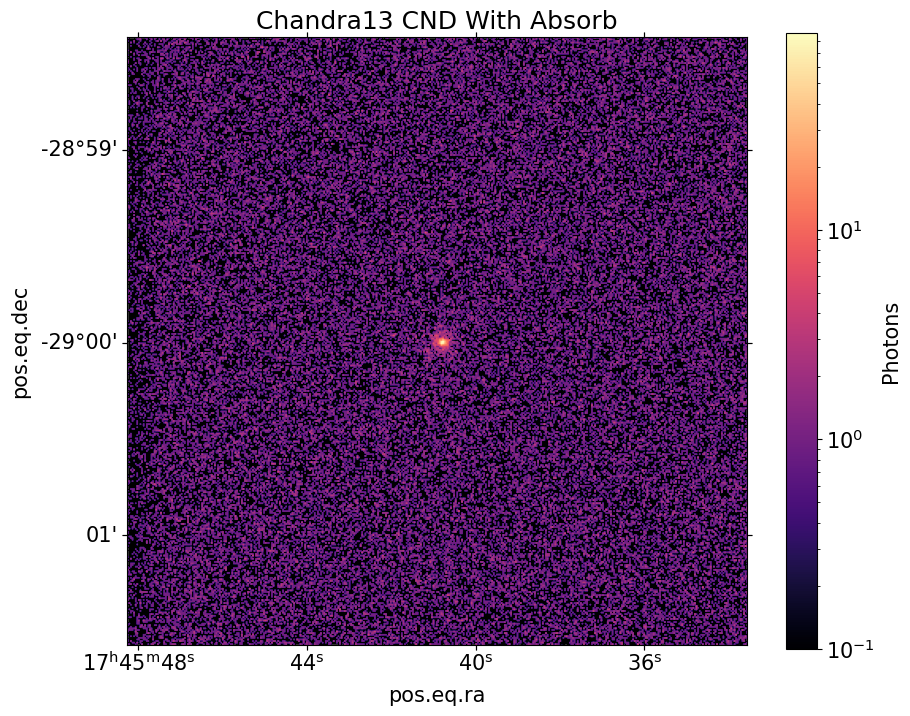

In [37]:
from astropy.io import fits
width = 800
with fits.open("noabs_RAM_dp15m2Ms_chandra230ks_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("Chandra13 CND With Absorb")

 

    
    fig.colorbar(p,label = 'Photons',shrink=0.80)


# Background

In [17]:
# original 100 arcsec radius image took too much memory, trying 50 and 25 
import numpy as np
from astropy.io import fits
from astropy import wcs
import astropy.units as u
from pprint import pprint
import soxs


In [18]:
with fits.open('/Volumes/Extern/output_00056/NC.fits') as hdu2:
    data2 = hdu2[0].data
    head2 = hdu2[0].header
    flux = data2*5.5e-9*(0.5**2) # applying the conversion so we have the file in flux
    filename = '/Volumes/Extern/output_00056/NC.fits'
    output_filename = filename.split('/')[-1]
    fits.writeto('flux_'+ output_filename, flux, header=head2, overwrite=True)
    

In [19]:
# original 100 arcsec radius image took too much memory, trying 50 and 25 

f = "flux_NC.fits"

fd = fits.getdata(f)
head = fits.getheader(f)


    #remove left side
fd1 = np.delete(fd, slice(0,150), 1)
    #remove right side (remember the right limit has already been reduced)
fd2 = np.delete(fd1,slice(212,362),1)
    #remove bottom
fd3 = np.delete(fd2,slice(0,150),0)
    #remove top(remember the top limit has already been reduced)
fd_done = np.delete(fd3,slice(212,362),0) 
fits.writeto("flux_NCcut.fits", fd_done, header= head, overwrite=True)
print("finished")

finished


In [20]:
ra0, dec0 = 266.42, -29 # center coords of image, from event file (updated to proper degrees)
#nx = 512 # size of image, got from file (remember to update if you use a cut version)
nx = 212# cutsize
dx = 0.5*u.arcsec # pixel size, you told me


In [21]:
w = wcs.WCS(naxis=2)
w.wcs.cunit = ["deg"]*2
w.wcs.crval = [ra0, dec0] # center of image in RA, Dec
w.wcs.crpix = [0.5*(nx+1)]*2 # center of image in pixel space
w.wcs.cdelt = [-dx.to_value("deg"), dx.to_value("deg")]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wheader = w.to_header()
pprint(wheader)

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                106.5 / Pixel coordinate of reference point            
CRPIX2  =                106.5 / Pixel coordinate of reference point            
CDELT1  = -0.00013888888888889 / [deg] Coordinate increment at reference point  
CDELT2  =  0.00013888888888889 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =               266.42 / [deg] Coordinate value at reference point      
CRVAL2  =                -29.0 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =                -29

In [22]:
#NSCbkgdtestflux.fits has the correct position in the sky (remember to update if you use a cut version)

with fits.open("flux_NCcut.fits") as f:
    data = f[0].data.copy()
    tot_flux = data.sum()
    header = f[0].header.copy()
    header.update(wheader)
    hdu = fits.PrimaryHDU(data, header=header)
    hdu.writeto("flux_NCcut_sky.fits", overwrite=True)


In [23]:
# Just a proof-of-concept, 
# best to ask Prof. Wang
agen = soxs.ApecGenerator(3.0, 9.0, 1000) #Changing this (to fewer bins or a smaller range (so far 3-10 has worked, will greatly reduce the photons generated 
spec = agen.get_spectrum(0.8, 1.0, 0.0, 1.0) # I normalized this to 1 at first (kT, abund, redshift, norm)
spec.rescale_flux(tot_flux, emin=4, emax=9) # now rescale by the flux from the file
spec.apply_foreground_absorption(11, model="tbabs") # n_H is The hydrogen column in units of 10**22 atoms/cm**2 we set 11


In [24]:
bkg_src = soxs.SimputSpectrum.from_spectrum(
    "NSCcut", spec, ra0, dec0, imhdu="flux_NCcut_sky.fits")

In [25]:
sim_cat = soxs.SimputCatalog.from_source(
    "NSCcut_simput.fits", bkg_src, overwrite=True
)

soxs : [INFO     ] 2024-04-30 19:33:13,906 Appending source 'NSCcut' to NSCcut_simput.fits.


In [26]:
soxs.instrument_simulator("NSCcut_simput.fits", "NSC13cut_230ks_evt.fits", (230, "ks"),
                          "chandra_aciss_sgra_cy13", [ra0, dec0], instr_bkgnd=False,
                          foreground=False, ptsrc_bkgnd=False, overwrite=True)

soxs : [INFO     ] 2024-04-30 19:33:14,892 Making observation of source in NSC13cut_230ks_evt.fits.
soxs : [WARNING  ] 2024-04-30 19:33:14,909 Using local file asgras_src.arf instead of the one from the database.
soxs : [WARNING  ] 2024-04-30 19:33:14,910 Using local file asgras_src.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-04-30 19:33:14,911 Using local file asgras_src.arf instead of the one from the database.
soxs : [WARNING  ] 2024-04-30 19:33:15,034 Using local file asgras_src.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-04-30 19:33:15,165 Using local file chandra_psf.fits instead of the one from the database.
soxs : [INFO     ] 2024-04-30 19:33:15,326 Detecting events from source NSCcut.
soxs : [INFO     ] 2024-04-30 19:33:15,327 Applying energy-dependent effective area from asgras_src.arf.
soxs : [INFO     ] 2024-04-30 19:33:16,282 Pixeling events.
soxs : [INFO     ] 2024-04-30 19:33:16,805 Scattering events with a multi_image-based PS

Scattering energies :   0%|          | 0/2673009 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-04-30 19:33:20,065 No backgrounds will be added to this observation.
soxs : [INFO     ] 2024-04-30 19:33:20,066 Writing events to file NSC13cut_230ks_evt.fits.
soxs : [INFO     ] 2024-04-30 19:33:25,912 Observation complete.


In [29]:
soxs.instrument_simulator("NSCcut_simput.fits", "NSClynx_230kscut_evt.fits", (230, "ks"),
                          "lynx_lxm", [ra0, dec0], instr_bkgnd=False,
                          foreground=False, ptsrc_bkgnd=False, overwrite=True)

soxs : [INFO     ] 2024-04-30 19:35:13,277 Making observation of source in NSClynx_230kscut_evt.fits.
soxs : [WARNING  ] 2024-04-30 19:35:13,315 Using local file xrs_mucal_3x10_3.0eV.arf instead of the one from the database.
soxs : [WARNING  ] 2024-04-30 19:35:13,316 Using local file xrs_mucal_3.0eV.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-04-30 19:35:13,317 Using local file xrs_mucal_3x10_3.0eV.arf instead of the one from the database.
soxs : [WARNING  ] 2024-04-30 19:35:13,364 Using local file xrs_mucal_3.0eV.rmf instead of the one from the database.
soxs : [WARNING  ] 2024-04-30 19:35:13,585 Using local file chandra_psf.fits instead of the one from the database.
soxs : [WARNING  ] 2024-04-30 19:35:13,585 Using local file chandra_psf.fits instead of the one from the database.
soxs : [INFO     ] 2024-04-30 19:35:13,672 Detecting events from source NSCcut.
soxs : [INFO     ] 2024-04-30 19:35:13,672 Applying energy-dependent effective area from xrs_mucal_3x10_3.

Scattering energies :   0%|          | 0/77363990 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-04-30 19:40:50,660 No backgrounds will be added to this observation.
soxs : [INFO     ] 2024-04-30 19:40:50,666 Writing events to file NSClynx_230kscut_evt.fits.
soxs : [INFO     ] 2024-04-30 19:43:56,707 Observation complete.


In [27]:
soxs.write_image("NSC13cut_230ks_evt.fits", "NSC13cut_230ks_img.fits", overwrite=True)

In [30]:
soxs.write_image("NSClynx_230kscut_evt.fits", "NSClynx_230kscut_img.fits", overwrite=True)

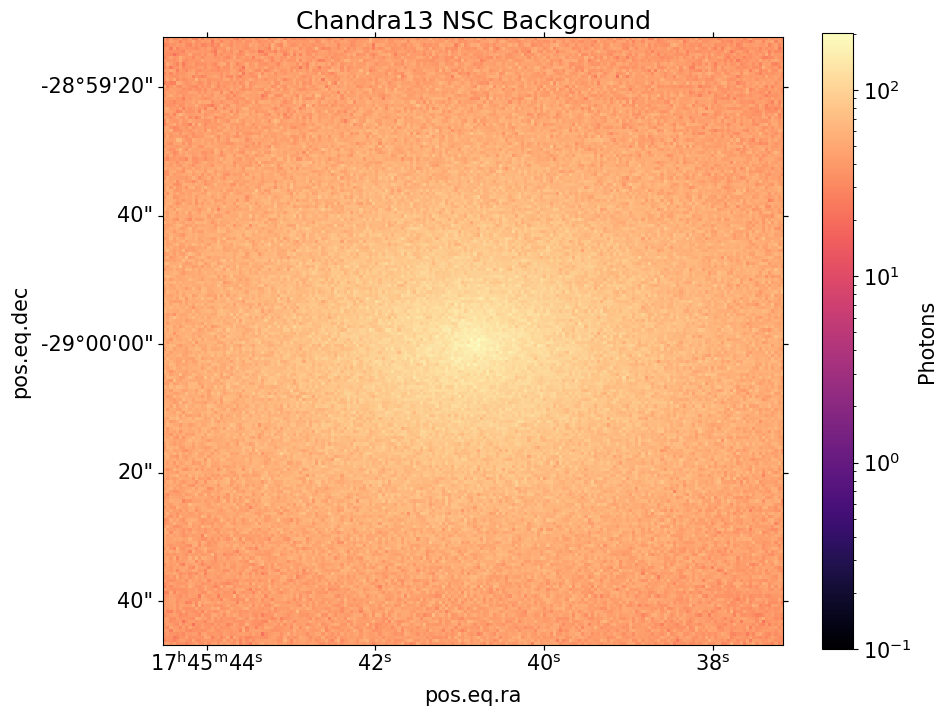

In [48]:
from astropy.io import fits
width = 400
with fits.open("NSC13cut_230ks_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("
    NSC Background")

 

    
    fig.colorbar(p,label = 'Photons',shrink=0.80)

### Merging with Chandra synthetic observations of Sgr A*

In [50]:
soxs.merge_event_files(["noabs_RAM_dp15m2Ms_chandra230ks_evt.fits", "NSC13cut_230ks_evt.fits"], "totchandra_RAM_230kscut_evt.fits", overwrite=True)

In [51]:
soxs.write_image("totchandra_RAM_230kscut_evt.fits", "totchandra_RAM_230kscut_img.fits", overwrite=True)

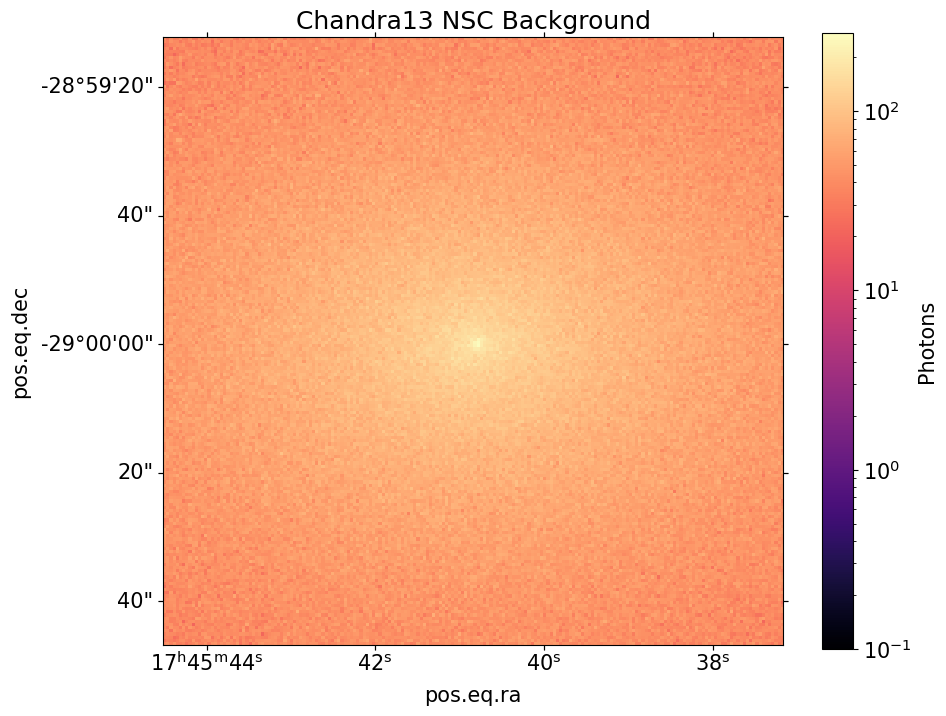

In [52]:
from astropy.io import fits
width = 400
with fits.open("totchandra_RAM_230kscut_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("Chandra13 NSC Background")

 

    
    fig.colorbar(p,label = 'Photons',shrink=0.80)

# Extracting Spectra

### Do note that to use specified regions you should create and save region areas for your specific synthetic observations with ds9

## XRISM

In [ ]:
soxs.write_spectrum("my_testwithdp100ks_xr_evt.fits", "my_testwithdp100ks28pt8test_xr_evt.pha",region="28pt8arcsec.reg",overwrite=True) 
soxs.write_spectrum("my_testwithdp100ksnodp_xr_evt.fits", "my_testwithdp100ksnodp28pt8test_xr_evt.pha",region="28pt8arcsec.reg",overwrite=True)

In [ ]:
ebin = np.linspace(1,15,2500)
fig, ax = soxs.plot_spectrum("my_testwithdp100ks28pt8test_xr_evt.pha",plot_energy=True, xmin=6.5,xmax = 6.8, noerr=False ,lw=2,ebins=ebin,label = 'With Doppler',color = 'black')
soxs.plot_spectrum("my_testwithdp100ksnodp28pt8test_xr_evt.pha",plot_energy=True, noerr=False,xmin=6.5,xmax = 6.8 ,ebins=ebin,lw=2,label = 'Without Doppler',color = 'orange',fig =fig, ax = ax)
plt.rcParams['font.size'] = '25'
x =[6.5,6.55,6.6,6.65,6.7,6.75,6.8]
values= ['6.5','6.55','6.6','6.65','6.7','6.75','6.8']
plt.xticks(x,values,fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Energy (keV)', fontsize=25)
plt.ylabel('Count Rate(counts/s/keV)', fontsize=25)
plt.title('Xrism 28.8" Region Fe Line 100ks Exposure')
plt.legend()
#plt.ylim(0.001,0.1) #for lynx
fig.set_size_inches(20, 10.5) 

## Lynx

In [ ]:
soxs.write_spectrum("my_testwithdp230ks_lx_evt.fits", "my_testwithdp230ksonearctest_lx_evt.pha",region="1arcsecnew.reg",overwrite=True)
soxs.write_spectrum("my_testwithdp230ksnodp_lx_evt.fits", "my_testwithdp230ksnodponearctest_lx_evt.pha",region="1arcsecnew.reg",overwrite=True) 

In [ ]:
ebin = np.linspace(1,15,5000)
fig, ax = soxs.plot_spectrum("my_testwithdp230ksonearctest_lx_evt.pha",plot_energy=True, noerr=False,xmin=6.5,xmax = 6.8 ,lw=2,ebins=ebin, label = 'With Doppler',color = 'black')
soxs.plot_spectrum("my_testwithdp230ksnodponearctest_lx_evt.pha",plot_energy=True, noerr=False,xmin=6.5,xmax = 6.8 ,ebins=ebin,lw=2,label = 'Without Doppler',color = 'orange',fig =fig, ax = ax)
#scale is default log
#plt.yscale('log') 
plt.rcParams['font.size'] = '25'
x =[6.5,6.55,6.6,6.65,6.7,6.75,6.8]
values= ['6.5','6.55','6.6','6.65','6.7','6.75','6.8']
plt.xticks(x,values,fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Energy (keV)', fontsize=25)
plt.ylabel('Count Rate(counts/s/keV)', fontsize=25)
plt.title('Lynx 1" Region Fe Line 230ks Exposure')
plt.legend()
plt.ylim(0.0005,1) #for lynx


fig.set_size_inches(20, 10.5) 

# Merged with background

#### Basic spectrum to mess with instead of NSC https://hea-www.cfa.harvard.edu/soxs/users_guide/spatial.html#betamodel

In [ ]:
soxs.write_spectrum("my_testwithdp230ks_bg_lx_evt.fits", "my_testwithdp230ks_bg_lx_evt.pha",region="1arcsecnew.reg",overwrite=True)

In [ ]:
ebin = np.linspace(1,15,5000)
fig, ax = soxs.plot_spectrum("my_testwithdp230ks_bg_lx_evt.pha",plot_energy=True, noerr=False,xmin=6.5,xmax = 6.8 ,lw=2,ebins=ebin, label = 'Bkgnd',color = 'black')
soxs.plot_spectrum("my_testwithdp230ksnodp_bg_lx_evt.pha",plot_energy=True, noerr=False,xmin=6.5,xmax = 6.8 ,ebins=ebin,lw=2,label = 'Without Doppler',color = 'orange',fig =fig, ax = ax)
#scale is default log
plt.rcParams['font.size'] = '25'
x =[6.5,6.55,6.6,6.65,6.7,6.75,6.8]
values= ['6.5','6.55','6.6','6.65','6.7','6.75','6.8']
plt.ylim(1e-3,5)
plt.xticks(x,values,fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Energy (keV)', fontsize=25)
plt.ylabel('Count Rate(counts/s/keV)', fontsize=25)
plt.title('Lynx 1" Region Fe Line 230ks Exposure background')
plt.legend()



fig.set_size_inches(20, 10.5) 